In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
data = torch.load('D:/rech/VeriRu/words/dataset_conv_cepstr_96.pt')
labels = torch.load('D:/rech/VeriRu/words/dataset_labels_cepstr_96.pt')

# r=torch.randperm(data.shape[0]) #шафлим
X = data
y = labels.reshape(1,-1)[0]

In [3]:
data.shape

torch.Size([11642, 14, 96])

In [4]:
from sklearn.model_selection import train_test_split
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'))

In [6]:
X_train.shape

(9313, 14, 96)

In [7]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
class RechNet_Conv(torch.nn.Module):
    def __init__(self):
        super(RechNet_Conv, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=(3,7), padding=(1,3))
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=10, out_channels=15, kernel_size=(2,5), padding=(1,0))
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(4 * 22 * 15,60)
        self.act3  = torch.nn.Tanh()
        torch.nn.Dropout(0.5)
        
        self.fc2   = torch.nn.Linear(60, 25)
        self.act4  = torch.nn.Tanh()
        torch.nn.Dropout(0.4)

        self.fc3   = torch.nn.Linear(25, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)

        x = self.act3(x)
        x = self.fc2(x)

        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
rech_net_conv = RechNet_Conv()

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
rech_net_conv = rech_net_conv.to(device)

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rech_net_conv.parameters(), lr=3.0e-4)

In [12]:
test_accuracy_history = []
test_loss_history = []
train_loss_history=[]

batch_size = 100

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = rech_net_conv.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
                
    test_preds = rech_net_conv.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    if epoch % 30 == 0:
        print(accuracy)
    if accuracy>0.9:
        print(accuracy)
#         break

tensor(0.7467)
tensor(0.9004)
tensor(0.9206)
tensor(0.9317)
tensor(0.9399)
tensor(0.9455)
tensor(0.9532)
tensor(0.9553)
tensor(0.9592)
tensor(0.9618)
tensor(0.9575)
tensor(0.9596)
tensor(0.9626)
tensor(0.9631)
tensor(0.9639)
tensor(0.9618)
tensor(0.9618)
tensor(0.9644)
tensor(0.9644)
tensor(0.9644)
tensor(0.9635)
tensor(0.9635)
tensor(0.9622)
tensor(0.9639)
tensor(0.9657)
tensor(0.9648)
tensor(0.9644)
tensor(0.9661)
tensor(0.9652)
tensor(0.9657)
tensor(0.9657)
tensor(0.9669)
tensor(0.9682)
tensor(0.9665)
tensor(0.9665)
tensor(0.9678)
tensor(0.9669)
tensor(0.9674)
tensor(0.9669)
tensor(0.9661)
tensor(0.9661)
tensor(0.9657)
tensor(0.9665)
tensor(0.9661)
tensor(0.9665)
tensor(0.9661)
tensor(0.9661)
tensor(0.9665)
tensor(0.9678)
tensor(0.9652)
tensor(0.9669)
tensor(0.9657)
tensor(0.9661)
tensor(0.9669)
tensor(0.9665)
tensor(0.9674)
tensor(0.9665)
tensor(0.9669)
tensor(0.9661)
tensor(0.9665)
tensor(0.9661)
tensor(0.9661)
tensor(0.9657)
tensor(0.9669)
tensor(0.9665)
tensor(0.9669)
tensor(0.9

[Text(0.5, 0, 'Эпохи обучения'), Text(0, 0.5, 'Accuracy')]

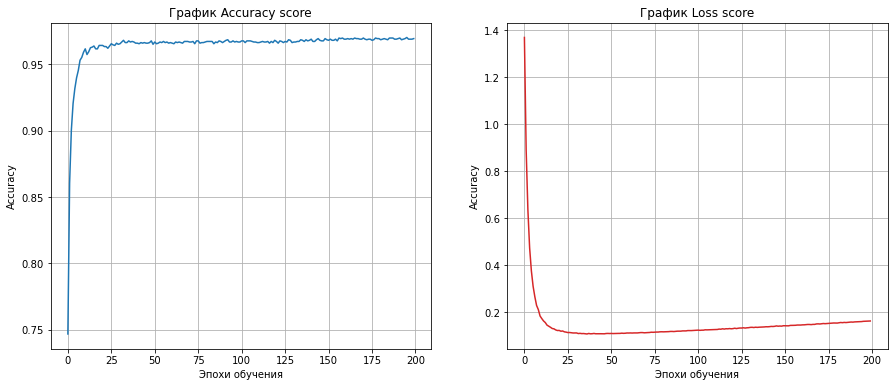

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(test_accuracy_history,'tab:blue')
ax1.set_title('График Accuracy score')
ax1.grid()
ax1.set(xlabel='Эпохи обучения', ylabel='Accuracy')

ax2.plot(test_loss_history,'tab:red')
ax2.set_title('График Loss score')
ax2.grid()
ax2.set(xlabel='Эпохи обучения', ylabel='Accuracy')

In [25]:
test = torch.load('D:/rech/test_conv.pt')
test = test.unsqueeze(1).float()
test = test.to(device)

In [26]:
preds = lenet5.forward(test)
preds.argmax(dim=1)

tensor([8, 3, 4, 5, 1, 4, 8], device='cuda:0')

# Сохранение модели

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in rech_net.state_dict():
    print(param_tensor, "\t", rech_net.state_dict()[param_tensor].size())

In [21]:
# Specify a path
PATH = "D:/rech/model/Kursach_conv_1.pt"

# Save
torch.save(rech_net_conv.state_dict(), PATH)

# Load
# lenet5.load_state_dict(torch.load(PATH))
# lenet5.eval()
